# Lecture 3: Intro to Neural Networks
In this lecture, we will begin examining how a neural network operates and how it is trained. To do this, we will build a perceptron that classifies the Iris dataset.

![neuron](https://appliedgo.net/media/perceptron/neuron.png)

The simplest form a neural network is called the __Perceptron__. A Perceptron is essentially a single neuron that performs __Binary Classification__, that is classification that only has two outputs.

![perceptron](https://cdn-images-1.medium.com/max/1600/1*n6sJ4yZQzwKL9wnF5wnVNg.png)

Our goal is to learn the weights in the green boxes above, the hypothesis being that there is some linear relationship between the inputs and the desired output. Let's express the image above as an equation.

$f(x) = \text{sign}(\boldsymbol{w}\boldsymbol{x} + b)$

Rembering that
$\boldsymbol{w}\boldsymbol{x} = \sum\limits_{j=1}^d w[j]\cdot x[j]$

In the case of the image above, $b$ is equivalent to $w_0$

This is all well and good, but how are we going to figure out the values of $\boldsymbol{w}$? Because perceptrons perform binary classification, it is very obvious when they make a mistake. Like a person does, let's learn from those mistakes!

Lets consider the simplest case of perceptron, a single input value $x$ and a corresponding single weight $w$

$y = \text{sign}(w \cdot x + b)$

If we were to make a classification mistake, we'd want to change $w$ and $b$ so that next time, we wouldnt make that mistake. Given the simplicity of the equation representing our perceptron, we can use the derivative with respect to the output to figure out how to change $w$ and $b$

$\frac{dy}{dw} = x$

$\frac{dy}{db} = 1$

If we should have guessed 1, but guessed -1 instead, then we want to pick $\frac{dy}{dw}$ to make $y$ more positive. So we should update $w$ and $b$ by

$w \leftarrow w + x$

$b \leftarrow b + 1$

If we instead guessed -1 when we should have guessed 1 we similarly want $\frac{dy}{dw}$ to be negative

$w \leftarrow w - x$

$b \leftarrow b - 1$

We can consolidate these two equations by defining the correct output to be $y_n$, then we can simply write

$w \leftarrow w + y_n\cdot x$

$b \leftarrow b + y_n$

And thats it! This is the basic form of __Gradient Descent__, a fundamental ML tool. If we iterate through the training data and update the weight and bias, we will eventually have a trained perceptron. Fortunately, this same principle applies to perceptrons with multiple inputs as well! We simply use vector operations for $w$ and $x$.

![grad_descent](https://cdn-images-1.medium.com/max/500/1*9sd4Ve9DH-k4EcNba5fGTA.jpeg)

Let's see if we can apply a perceptron algorithm to the Iris dataset introduced in the previous lecture

In [1]:
# start by importing some of the modules we're going to use for this lecture
import mxnet as mx
from mxnet import nd
from mxnet import gluon
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

iris = datasets.load_iris()

In [4]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

We want to perform binary classification, but Iris normally has 3 possible output classes. Let's drop the third.

In [13]:
iris_data = iris.data[:100]
iris_labels = iris.target[:100]

In [14]:
iris_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

Great! Just like before lets shuffle this and split it into training and validation sets.

In [16]:
iris_data, iris_labels = shuffle(iris_data, iris_labels)
train_data = iris_data[:80]
val_data = iris_data[80:]
train_labels = iris_labels[:80]
val_labels = iris_labels[80:]

Finally, lets remove all but the first feature

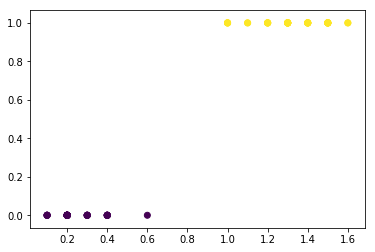

In [51]:
redux_feature = 3

train_data_redux = train_data[:,redux_feature]
val_data_redux = val_data[:,redux_feature]

# now lets plot our input feature versus the output for the training set
plt.scatter(train_data_redux, train_labels, c=train_labels)

Great! This looks like it should be linearlly seperable (what the perceptron specializes in. Lets go ahead and implement it.

In [52]:
# initialize learnable parameters
weight = 0
bias = 0

# iterate through all the training data
for i, data in enumerate(train_data_redux):
    # make our prediction
    guess = np.sign(weight*data + bias)
    correct = train_labels[i]
    # perceptron wants labels to be -1 or 1, if correct is 0, switch it to -1
    if correct == 0:
        correct = -1
    # check if our guess is correct, update our parameters if we were wrong
    if guess != correct:
        weight = weight + correct*data
        bias = bias + correct
        
print(weight)
print(bias)

2.3
-2


In [53]:
# define a function that uses our learned values to make a new prediction
def predict(input, weight, bias):
    guess = np.sign(weight*input + bias)
    # for comparison to the dataset, we want labels to be 0 or 1
    if guess == -1:
        guess = 0
    return guess

In [54]:
# lets check how our model learned!
total_correct = 0
for i, data in enumerate(val_data_redux):
    guess = predict(data, weight, bias)
    if guess != val_labels[i]:
        print("Incorrect")
    else:
        print("Correct")
        total_correct += 1
print("Accuracy: %f%%" % (100*total_correct/len(val_labels)))

Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Accuracy: 100.000000%


Great! If you were using feature 3, chances are your network did very well.

## Activity: Perceptron Sandbox
What happens if we try to learn a perceptron model using other features? Go back to the redux_features variable and change it. What is the result? Why do you think this happens? Do you have any ideas for improving the accuracy? If you look at the results of other tables, you might notice they have different accuracy despite everything else seeming similar. Can you explain why that's happening?

## Perceptron With Multiple Features
Now that we looked at the simple case, let's try training a perceptron that uses all 4 of Iris' input features.

In [81]:
# initialize a weights vector and a bias for our new 4 features perceptron
weights = np.zeros(train_data[0].shape)
bias = 0

In [85]:
# iterate through all the training data
for i, data in enumerate(train_data):
    output = 0
    # note that now data is a vector of features
    # this means we'll have to build up the output from each feature
    for j, feature in enumerate(data):
        output += feature * weights[j]
    # add the bias after all features are accumulated
    output += bias
    # finally, apply the sign to get our guess
    guess = np.sign(output)
    
    # like before, we want to compare to the correct label
    correct = train_labels[i]
    # if correct is 0, we want to make it -1 for proper training
    if correct == 0:
        correct = -1
    
    # check if we got the correct answer, update our parameters if we did not
    if guess != correct:
        # now apply the updates
        for j in range(len(data)):
            weights[j] = weights[j] + correct*data[j]
        bias = bias + correct

print(weights)
print(bias)

[-1.3 -4.6  7.2  3.3]
-1


Cool! We learned a full iris model! Notice that this barely looks different from the case when we learned 1 feature, there are just a couple of added for loops. Let's see how accurate it is.

In [86]:
def full_predict(input, weights, bias):
    # again, iterate through features and accumulate
    output = 0
    for i, feature in enumerate(input):
        output += feature*weights[i]
    # add the bias
    output += bias
    # take the sign to find the guess
    guess = np.sign(output)
    # map guesses of -1 to 0 for compatibility with iris
    if guess == -1:
        guess = 0
    return guess

In [88]:
# lets check how our model learned!
total_correct = 0
for i, data in enumerate(val_data):
    guess = full_predict(data, weights, bias)
    if guess != val_labels[i]:
        print("Incorrect")
    else:
        print("Correct")
        total_correct += 1
print("Accuracy: %f%%" % (100*total_correct/len(val_labels)))

Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Accuracy: 100.000000%


Woohoo! If things went well, this model got 100% accuracy on Iris, that's much better than the KNN algorithm we looked at.

## Activity: Stump the Perceptron
Do you think Perceptron is always better than KNN? Are there any cases where the Perceptron doesn't work at all? We're going to make our own toy datasets and see how learnable they are. Before you start, let's look at an example and some utility functions.

In [119]:
# as an example, generate some random two dimensional data

def my_data_generator(size):
    datalist = []
    labels = []
    for i in range(size):
        # generate a label thats 1 or -1
        label = 2*np.random.randint(2) - 1
        # now based on that label, apply some function
        x = 2*label + 5
        y = -.5*label
        # finally, lets add some noise to make it more interesting
        x += np.random.randn()
        y += np.random.randn()
        datalist.append([x, y])
        labels.append(label)
    return np.asarray(datalist), np.asarray(labels)

In [120]:
data, target = my_data_generator(10)

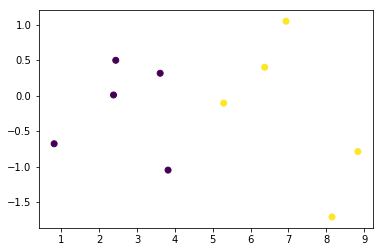

In [123]:
plt.scatter(data[:,0], data[:,1], c=target)

Neat, this looks pretty seperable so we'd expect a perceptron to do well. Lets make a training and validation set too


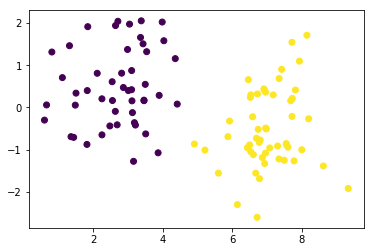

In [174]:
train_data, train_labels = my_data_generator(100)
val_data, val_labels = my_data_generator(20)
plt.scatter(train_data[:,0], train_data[:,1], c=train_labels)

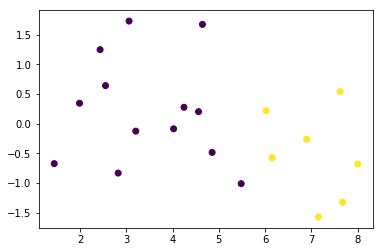

In [175]:
plt.scatter(val_data[:,0], val_data[:,1], c=val_labels)

In [176]:
# define a function that trains a perceptron
def train_perceptron(train_data, train_labels):
    num_features = train_data.shape[1]
    # initialize learnable parameters
    weights = np.zeros(num_features)
    bias = 0
    
    for i, data in enumerate(train_data):
        # compute the output by summing features
        output = 0
        for j in range(num_features):
            output += data[j]*weights[j]
        output += bias
        # apply sign to get our guess
        guess = np.sign(output)
        correct = train_labels[i]
        
        if guess != correct:
            #update parameters if guess was wrong
            for j in range(num_features):
                weights[j] = weights[j] + correct*data[j]
            bias = bias + correct
            
    return weights, bias           

In [177]:
# train a new perceptron using our data
weights, bias = train_perceptron(train_data, train_labels)
print(weights)
print(bias)

[ 1.98674189 -8.96837426]
-13


In [178]:
# now define a function to test the perceptron
def test_perceptron(weights, bias, val_data, val_labels):
    num_features = val_data.shape[1]
    total_correct = 0
    for i, data in enumerate(val_data):
        output = 0
        for j in range(num_features):
            output += weights[j] * data[j]
        output += bias
        guess = np.sign(output)
        correct = val_labels[i]
        
        if guess == correct:
            total_correct += 1
    return total_correct / val_data.shape[0]

In [179]:
test_perceptron(weights, bias, val_data, val_labels)

0.75

Not bad! Our perceptron here does an alright job, although not perfect. Here are a few things to try:
* Make a dataset that the perceptron can learn with very high accuracy
* Make a dataset that the perceptron can not learn
* Make a dataset that a person can learn, but the perceptron cannot
* For the last dataset, what changes could you make to help?

## Comparison to KNN
Now, lets try classifying your dataset with KNN, and see how it goes.

In [197]:
# lets define some utility functions to make things cleaner

def euclid_distance(a, b):
    return np.linalg.norm(a - b)

def get_neighbors(distances, train_labels, k=5):
    closest_points = nd.topk(nd.array(distances), k=5, is_ascend=True).asnumpy().astype(np.int)
    return [train_labels[point] for point in closest_points]

def best_guess(labels):
    labels = np.asarray(labels)
    return np.argmax(np.bincount(labels+1))      

In [204]:
# implement KNN the same way as the previous lecture
def KNN_Accuracy(train_data, train_labels, val_data, val_labels, k=5):
    total_correct = 0
    # iterate through validation samples
    for i, sample in enumerate(val_data):
        # compute distances to all points in the training set
        distances = np.asarray([euclid_distance(sample, neighbor) for neighbor in train_data])
        # find closest k neighbors
        knn = get_neighbors(distances, train_labels, k)
        # determine which label is best
        guess = best_guess(knn) - 1
        # check if we got the right answer
        if guess == val_labels[i]:
            total_correct += 1
    print("Accuracy: %f%%" % (100*total_correct / val_data.shape[0]))

In [205]:
KNN_Accuracy(train_data, train_labels, val_data, val_labels)

Accuracy: 90.000000%


Interesting! KNN actually does better in this case. Try to figure out why. Can you consistently create a dataset where KNN outperforms the perceptron? How about vice-versa?